![title](https://images.unsplash.com/photo-1551817958-795f9440ce4d?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&h=400&w=1050&q=80)

<br><br>
<div align="center">
    <h1>Analyzing Music using the Spotify API</h1>
    <h4>ST445 Managing and Visualising Data</h4>
    <h4>Andreas Stöffelbauer (202037521)</h4>
    <h4>28 Jan 2020</h4>
</div>

## 1. Introduction
Music plays an important part in my life. Nevertheless, I could not say _why_ exactly I prefer some songs over others, or how my favorite songs differ from the rest. Of course, what makes a good song is highly subjective. I will therefore not even try to stay subjective here. Instead, the goal of this notebook is to explore _my_ music preferences. In other words, I want to find out what kind of music I enjoy listening to most.

For that purpose, I will use Spotify's Web API. The API provides access to metadata about artists, albums and tracks from Spotify's Data Catalogue. In addition, it also provides user related data such as playlists.

#### Research Questions
In this notebook, my goal is to answer the following questions, among others.

- ___What kind to songs do I listen to most and how can I summarize them quantitatively and visually?___
- ___Can the songs saved in my personal Spotify library be grouped into clusters of similar songs?___
- Based on that, ***can I infer what makes me like a song?*** For example, do I like fast songs or slow ones? Do I prefer speechy songs over songs that contain no vocals? Do I like songs people can dance to?
- ***Can audio features be used to determine the popularity of a song?***

In short, I will explore the world of music as well as my own music preferences, but in an systematic and analytic fashion. In addition, another important goal for this notebook is to use many of the methods and tools learned in the course of _ST445 Managing and Visualising Data_.

#### Notebook Structure
The notebook is structured as follows.

- **Chapter 1**: Introduction including a brief overview of Spotipy (a Python library), the Spotify API, and the data I am going to use.
- **Chapter 2**: Getting acquainted with the API while also acquiring a first analytic grasp of my music preferences by analyzing one of my favorite artists, Post Malone.
- **Chapter 3**: Analyzing my music library. This is the center piece of the notebook in which I will analyze, cluster, and visualize all the songs saved in my Spotify library, i.e. the songs I listen to most often.
- **Chapter 4**: Using audio features to predict the popularity of a song will help me understand if (and which) audio features determine popularity.
- **Chapter 5**: In this final section, I will take a look at how often artists collaborate using network analysis techniques.

### 1.1. About Spotipy

I use the Python library _Spotipy_ to interact with Spotify's web API rather than interact with it directly via URL queries. The biggest benefit of working with such a wrapper library is that it allows developers to avoid some of the more cumbersome aspects of dealing with a web API. For example, instead of being required to provide my authentication keys for each URL request, Spotipy allows me to provide my identification (client_ID and client_secret) only once per session and includes them automatically in every subsequent request I make.

See the documentation below for more details.
- Spotipy - [GitHub Repository](https://github.com/plamere/spotipy)  
- Spoitpy - [Read the Docs](https://spotipy.readthedocs.io/en/2.16.1/)

### 1.2 About the Spotify API

<img src="https://developer.spotify.com/assets/branding-guidelines/logo@2x.png" width="80%" align="center"/>
<!--![title](https://developer.spotify.com/assets/branding-guidelines/logo@2x.png)-->

Spotify is a Swedish audio streaming provider; with 320 million monthly active users, it is the largest such streaming service globally. Its Data Catalogue comprises some 60 million songs ([Source](https://en.wikipedia.org/wiki/Spotify)).

The Spotify Web API provides endpoints to access this catalogue, including information about music, artists and albums. It is based on REST principles and the JSON format. For more details on the Spotify API, see the [Spotify API Documentation](https://developer.spotify.com/documentation/web-api/).

#### Data Dictionary
In this notebook, I am most interested in the audio features as they allow me to take a "quantitative" approach to analyzing songs and music preferences. The following data dictionary summarizes the audio features that I will be focusing on throughout this notebook.

| Feature | Description | Data Type |
| --- | --- | --- |
| id | the primary identifier for the track, generated by Spotify | string |
| artists | the list of artists credited for production of the track | list of strings |
| popularity | the popularity of the song lately | int in [0,100] |
| acousticness | the relative metric of the track being acoustic | float in [0,1] |
| instrumentalness | the relative ratio of the track being instrumental | float in [0,1] |
| danceability | the relative measurement of the track being danceable | float in [0,1] |
| energy | the energy of a track | float in [0,1] |
| liveness | the relative duration of the track sounding as a live performance | float in [0,1] |
| valence | the positivity or happiness of a track |float in [0,1] |
| explicit | whether the track contains explicit content or not | binary in {0,1} |
| speechiness | the relative length of the track containing any kind of human voice |float in [0,1] |
| tempo | the tempo of the track in Beat Per Minute (BPM) | int in [0,244] |

>**Note**: Id, artists, and popularity are not audio features, strictly spearking, but I will require them nevertheless.

## 2. Exploring the API & my Favorite Artist

I start off by exploring one of my favorite artists, Post Malone, in order to get a first grasp of the API, what kind of data it provides, and how to get it.

<img src="https://i.scdn.co/image/93fec27f9aac86526b9010e882037afbda4e3d5f" width="300" align="center"/>
<!-- ![title](https://i.scdn.co/image/93fec27f9aac86526b9010e882037afbda4e3d5f) -->

In [1]:
# api library
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

# data analysis libraries
import numpy as np
import pandas as pd
import json

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go
from utils import radar_plot
from IPython.display import Image, display, HTML

> **Note**: It is usually best practice to include all the import statements at the very top. However, with jupyter notebooks, I often find it neater to import new libraries for each subsection, especially when the notebook requires many libraries.

### 2.1 User Authentication
Spotify requires any "App" (broadly defined) that wishes to access its web API to be authorized on the _Spotify for Developers_ platform, including this notebook. Once registered, developers are provided with a _client ID_ and _client secret_ required for making API requests.

Spotify offers three different _authorization flows_, depending on the App's requirements. For generic, non-user related data, it is sufficient to provide the two keys, but as we will see later, in order to access user-related data, an additional authorization step is required.

In [2]:
# authentication keys
with open('keys.json') as k:
    keys = json.load(k)['Spotify']

In [3]:
# simple user authentication without ability to access any personal data
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=keys['client_ID'],
                                                           client_secret=keys['client_secret']))

### 3.2 API Requests
The objective here is to get the audio features of Post Malone's top 10 tracks. However, this is not possible with a single API call. To get the features, I must first request the ID of the artist. Subsequently, I can request some metadata of the artist's top 10 tracks, including their track IDs, names, and popularity scores. Finally, I can use the obtained track IDs to request the audio features, which I combine into a single data frame.

In [4]:
# get artist ID
results = sp.search(q='Post Malone', type='artist')
items = results['artists']['items']
artist = items[0]
artistID = artist['id']
print(artist['name'], artistID)

Post Malone 246dkjvS1zLTtiykXe5h60


In [5]:
# get top 10 tracks
res = sp.artist_top_tracks(artistID)

# extract song name, id and popularity from the json response
tracks = pd.DataFrame()
for i, track in enumerate(res['tracks']):
    tracks.loc[i, 'name'] = track['name']
    tracks.loc[i, 'id'] = track['id']
    tracks.loc[i, 'popularity'] = track['popularity']
    
tracks.head()

name                      id  \
0                                        Circles  21jGcNKet2qwijlDFuPiPb   
1                     rockstar (feat. 21 Savage)  0e7ipj03S05BNilyu5bRzt   
2  Sunflower - Spider-Man: Into the Spider-Verse  0RiRZpuVRbi7oqRdSMwhQY   
3                                           Wow.  7xQAfvXzm3AkraOtGPWIZg   
4                                     Better Now  7dt6x5M1jzdTEt8oCbisTK   

   popularity  
0        88.0  
1        84.0  
2        81.0  
3        82.0  
4        82.0

In [6]:
# get audio features
features_all = sp.audio_features(tracks.id)
features_all = pd.DataFrame.from_records(features_all)

# drop unwanted cols
keep = ['id', 'danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo']
features = features_all[keep]
features.head()

id  danceability  energy  speechiness  acousticness  \
0  21jGcNKet2qwijlDFuPiPb         0.695   0.762       0.0395         0.192   
1  0e7ipj03S05BNilyu5bRzt         0.585   0.520       0.0712         0.124   
2  0RiRZpuVRbi7oqRdSMwhQY         0.755   0.522       0.0575         0.533   
3  7xQAfvXzm3AkraOtGPWIZg         0.829   0.539       0.2080         0.136   
4  7dt6x5M1jzdTEt8oCbisTK         0.680   0.578       0.0400         0.331   

   instrumentalness  valence    tempo  
0          0.002440    0.553  120.042  
1          0.000070    0.129  159.801  
2          0.000000    0.925   89.960  
3          0.000002    0.388   99.960  
4          0.000000    0.341  145.038

In [7]:
# merge tracks and features
PostMalone = pd.merge(tracks, features, on='id', how='outer').set_index('id')

# some further processing
PostMalone['tempo'] = PostMalone['tempo']/244
PostMalone['popularity'] = PostMalone['popularity']/100
PostMalone.head()

name  \
id                                                                      
21jGcNKet2qwijlDFuPiPb                                        Circles   
0e7ipj03S05BNilyu5bRzt                     rockstar (feat. 21 Savage)   
0RiRZpuVRbi7oqRdSMwhQY  Sunflower - Spider-Man: Into the Spider-Verse   
7xQAfvXzm3AkraOtGPWIZg                                           Wow.   
7dt6x5M1jzdTEt8oCbisTK                                     Better Now   

                        popularity  danceability  energy  speechiness  \
id                                                                      
21jGcNKet2qwijlDFuPiPb        0.88         0.695   0.762       0.0395   
0e7ipj03S05BNilyu5bRzt        0.84         0.585   0.520       0.0712   
0RiRZpuVRbi7oqRdSMwhQY        0.81         0.755   0.522       0.0575   
7xQAfvXzm3AkraOtGPWIZg        0.82         0.829   0.539       0.2080   
7dt6x5M1jzdTEt8oCbisTK        0.82         0.680   0.578       0.0400   

                        acousticness  instrumentalness  valence     tempo  
id                                                                         
21jGcNKet2qwijlDFuPiPb         0.192          0.002440    0.553  0.491975  
0e7ipj03S05BNilyu5bRzt         0.124          0.000070    0.129  0.654922  
0RiRZpuVRbi7oqRdSMwhQY         0.533          0.000000    0.925  0.368689  
7xQAfvXzm3AkraOtGPWIZg         0.136          0.000002    0.388  0.409672  
7dt6x5M1jzdTEt8oCbisTK         0.331          0.000000    0.341  0.594418

> **Note**: While most features are between 0 and 1 by definition, popularity and tempo are not. For many visualizations, however, they need to have a similar range. Therefore, I simply divide them by 100 and 244, respectively (their maximum values). In addition, note that since this is a very well maintained and structured API, there are no missing values or huge outliers.

### 2.3 Radar Chart
Throughout this notebook, I will make use of **radar charts** to visualize the audio features - either for a single track (see below) or for an average of a collection of tracks, such as a playlist. However, I drop _explicitness_ and _mode_ from the features as they are binary variables.

>**Note**: The radar charts are not rendered in the jupyter notebook file. Please see the HTML version of the notebook in order to see them properly.

In [8]:
radar_vars = ['danceability', 'energy', 'speechiness', 
              'acousticness', 'instrumentalness', 'valence', 'tempo']

def radar_plot(features):
    s = features[radar_vars]  
    fig = px.line_polar(r=s, theta=s.index, line_close=True, title = features['name'], range_r=[0,1])
    fig.update_traces(fill='toself')
    # fig.write_image("images/sunflower.png")
    fig.show()
    
radar_plot(PostMalone.loc['0RiRZpuVRbi7oqRdSMwhQY'])

In [9]:
radar_plot(PostMalone.loc['7dt6x5M1jzdTEt8oCbisTK'])

The above radar charts are of two of my favorite Post Malone songs. They score similarly on some audio features such as danceability, energy and speechiness, but they differ on others. While _Sunflower_ scores higher on valence and acousticness, _Better Now_ scores higher on energy and tempo. Click on the links below to listen to the two songs - the differences will be very obvious.

- Sunflower by Post Malone - [YouTube](https://www.youtube.com/watch?v=ApXoWvfEYVU)
- Better Now by Post Malone - [YouTube](https://www.youtube.com/watch?v=UYwF-jdcVjY)

> **Note**: For many songs, the Spotify API also provides a URL to a 30 seconds preview of the song. Some songs (including these two), however, do not have such a preview URL. Therefore, I added the links to YouTube instead.

In [10]:
# no peview URLs for the two songs
# songIDs = ['0RiRZpuVRbi7oqRdSMwhQY', '7dt6x5M1jzdTEt8oCbisTK']
# res = sp.tracks(songIDs, market='US')
# for track in res['tracks']:
#     name = track['name']; artist = track['artists'][0]['name']
#     link = track['preview_url']
#     display(HTML(f'{name} by {artist} - <a href="{link}"> preview</a>'))

## 3. My Spotify Library
In this main part of the notebook, I analyze all the songs saved in my Spotify library, i.e. the songs I listen to most often. For that purpose, I must first collect the audio features of those songs via the web API. I then conduct a first exploratory analysis and present some plots. Subsequently, I perform a k-means clustering to group similar songs and visualize as well as interpret the results.

### 3.1 User Authentication
As mention earlier, in order to access any personal data, the user authentication is somewhat stricter. More specifically, I must provide a _redirect URI_ which requires me to authorize this notebook's access to my personal data - in particular to read my playlists. Accordingly, I set the scope to "_playlist-read-private_" (to find more about scopes, see [here](https://developer.spotify.com/documentation/general/guides/scopes/)).

In [11]:
# user authentication #2
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=keys['client_ID'],
                                               client_secret=keys['client_secret'],
                                               # redirect to my personal website
                                               redirect_uri = 'https://astoeffelbauer.github.io/',
                                               # set scope to read only
                                               scope ='playlist-read-private'))

### 3.2 Data Collection via the Web API
In order to get the data that I need, i.e. the audio features of all songs in my personal library, I take the following steps.
1. First, I request the IDs of all the playlists saved in my library. This includes playlist I have created myself as well as public playlists that I "follow".
2. Once I have a list of playlist IDs, I can loop over it to request the IDs of all the songs in those playlists.
3. Finally, I can request the audio features for those songs, which I combine into a single data frame.

In [12]:
# get IDs of all my saved playlists
res = sp.current_user_playlists()
playlist_IDs = [playlist['id'] for playlist in res['items']]

In [13]:
# get all tracks into a list of dictionaries
# just use id, name and popularity
tracks = list()
for i, ID in enumerate(playlist_IDs):
    res = sp.playlist_tracks(ID, market='US', limit=100) 
    for track in res['items']:
        try:
            d = dict()
            d['id'] = track['track']['id']
            d['name'] = track['track']['name']
            d['popularity'] = track['track']['popularity']
            tracks.append(d)
        except TypeError:
            print('encountered faulty response')

> **Note**: I sometimes encountered an irregular response that raised a TypeError. In order to keep the loop going, I simply caught the error to skip that iteration. Moreover, note that I only request a maximum of 100 songs per playlist even though some comprise up to or even above 300 songs. The reason is that most playlist comprise similar songs (e.g. just R&B songs) and those playlists may be much bigger than any of my self-curated playlists. Therefore, in order to get a more balanced collection of genres, I cut off the longer playlists.

In [14]:
song_IDs = [track['id'] for track in tracks]
print(f'# playlists: {len(playlist_IDs)}')
print(f'# songs: {len(song_IDs)}')
print(f'# unique songs: {len(set(song_IDs))}')

# playlists: 39
# songs: 1599
# unique songs: 1338


In [16]:
# retrieve audio features for all tracks
features_raw = pd.DataFrame()
offset = 0
while offset < len(song_IDs):
    features_temp = sp.audio_features(song_IDs[offset:offset+100])
    features_temp = pd.DataFrame(features_temp)
    features_raw = pd.concat([features_raw, features_temp], axis=0)
    offset += 100

features_raw.set_index('id', inplace=True)

> **Note**: A rate limit of 100 songs per request applies. However, by using an offset within the loop, I can get the audio features for all >1000 songs in my library.

In [17]:
# some further processing (scaling)
features_all = features_raw.copy()
features_all['tempo'] = features_all['tempo']/244
features_all['loudness'] = 1+features_all['loudness']/max(abs(features_all['loudness']))

In [18]:
# features I want to keep
feat_keep = ['danceability', 'energy',  'loudness', 'speechiness', 'acousticness', 'instrumentalness', 
             'valence', 'tempo', 'liveness',]

In [19]:
# merge tracks and features
tracks_df = pd.DataFrame(tracks).set_index('id')
features = features_all[feat_keep]
MySongs = pd.concat([tracks_df, features], axis=1)
MySongs = MySongs.drop_duplicates()
MySongs['popularity'] = MySongs['popularity']/100
print('dimensionality:', MySongs.shape)
MySongs.head()

dimensionality: (1338, 11)


name  \
id                                                                          
1dWxSS2a93X4XVfs1mSYkB                                           Bluebird   
7etGs69UCKGxJIHxKFe7BD                                 River Flows in You   
3Dgmyz32dxvtxvUTPS0CUI  Vivaldi Variation (Arr. for Piano from Concert...   
6388HGab7WTMCCJYYtHQ2z                                            Moments   
24t1mpJc8FTPAkYjFdf9NQ  Piano Sonata No. 14 in C-sharp minor, Op. 27, ...   

                        popularity  danceability   energy  loudness  \
id                                                                    
1dWxSS2a93X4XVfs1mSYkB        0.62         0.448  0.11100  0.530091   
7etGs69UCKGxJIHxKFe7BD        0.55         0.223  0.18300  0.522998   
3Dgmyz32dxvtxvUTPS0CUI        0.64         0.429  0.25800  0.613076   
6388HGab7WTMCCJYYtHQ2z        0.56         0.453  0.04520  0.376434   
24t1mpJc8FTPAkYjFdf9NQ        0.59         0.141  0.00123  0.000000   

                        speechiness  acousticness  instrumentalness  valence  \
id                                                                             
1dWxSS2a93X4XVfs1mSYkB       0.0353         0.991             0.898   0.0755   
7etGs69UCKGxJIHxKFe7BD       0.0491         0.988             0.918   0.1860   
3Dgmyz32dxvtxvUTPS0CUI       0.0549         0.957             0.893   0.0972   
6388HGab7WTMCCJYYtHQ2z       0.0446         0.993             0.936   0.0930   
24t1mpJc8FTPAkYjFdf9NQ       0.0429         0.994             0.942   0.0843   

                           tempo  liveness  
id                                          
1dWxSS2a93X4XVfs1mSYkB  0.306393    0.0974  
7etGs69UCKGxJIHxKFe7BD  0.294811    0.1030  
3Dgmyz32dxvtxvUTPS0CUI  0.322988    0.1150  
6388HGab7WTMCCJYYtHQ2z  0.541910    0.0975  
24t1mpJc8FTPAkYjFdf9NQ  0.320307    0.1100

In [20]:
# save dataframe
# MySongs.to_pickle("data/MySongs.pkl")

# load dataframe
#MySongs = pd.read_pickle("data/MySongs.pkl")

In [21]:
# re-create features data frame without duplicates
features = MySongs[feat_keep]
print('dimensionality:', features.shape)
features.head()

dimensionality: (1338, 9)


danceability   energy  loudness  speechiness  \
id                                                                     
1dWxSS2a93X4XVfs1mSYkB         0.448  0.11100  0.530091       0.0353   
7etGs69UCKGxJIHxKFe7BD         0.223  0.18300  0.522998       0.0491   
3Dgmyz32dxvtxvUTPS0CUI         0.429  0.25800  0.613076       0.0549   
6388HGab7WTMCCJYYtHQ2z         0.453  0.04520  0.376434       0.0446   
24t1mpJc8FTPAkYjFdf9NQ         0.141  0.00123  0.000000       0.0429   

                        acousticness  instrumentalness  valence     tempo  \
id                                                                          
1dWxSS2a93X4XVfs1mSYkB         0.991             0.898   0.0755  0.306393   
7etGs69UCKGxJIHxKFe7BD         0.988             0.918   0.1860  0.294811   
3Dgmyz32dxvtxvUTPS0CUI         0.957             0.893   0.0972  0.322988   
6388HGab7WTMCCJYYtHQ2z         0.993             0.936   0.0930  0.541910   
24t1mpJc8FTPAkYjFdf9NQ         0.994             0.942   0.0843  0.320307   

                        liveness  
id                                
1dWxSS2a93X4XVfs1mSYkB    0.0974  
7etGs69UCKGxJIHxKFe7BD    0.1030  
3Dgmyz32dxvtxvUTPS0CUI    0.1150  
6388HGab7WTMCCJYYtHQ2z    0.0975  
24t1mpJc8FTPAkYjFdf9NQ    0.1100

### 3.3 Exploratory Data Analysis

We can take a first look at the correlations between audio features and see some unsurprising patterns. For example, there is a strong positive correlation between acousticness and instrumentalness as well as between energy and loudness. At the same time, acousticness/instrumentalness are negatively correlated with danceability/valence. Perhaps more surprisingly is the slightly negative correlation between tempo and danceability. 

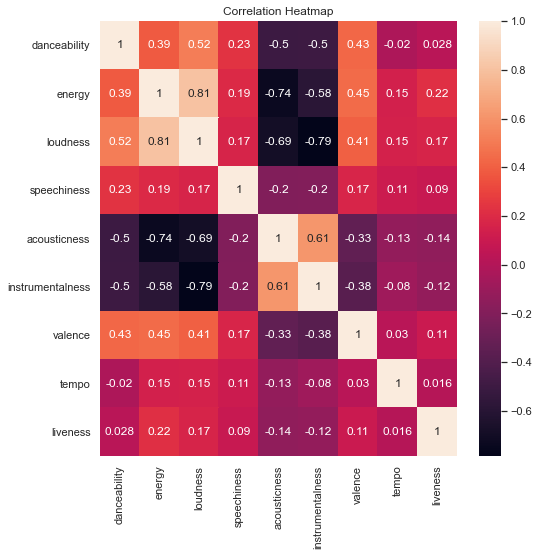

In [22]:
corr = features.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

We can observe even more details about the relationships between audio features in the pairsplot below. To name just a few, the relationships between energy and acousticness as well as between energy and loudness appear to be nonlinear. In addition, some variables such as energy and acousticness appear to be multi-modal, indicating that they there may be subgroups within.

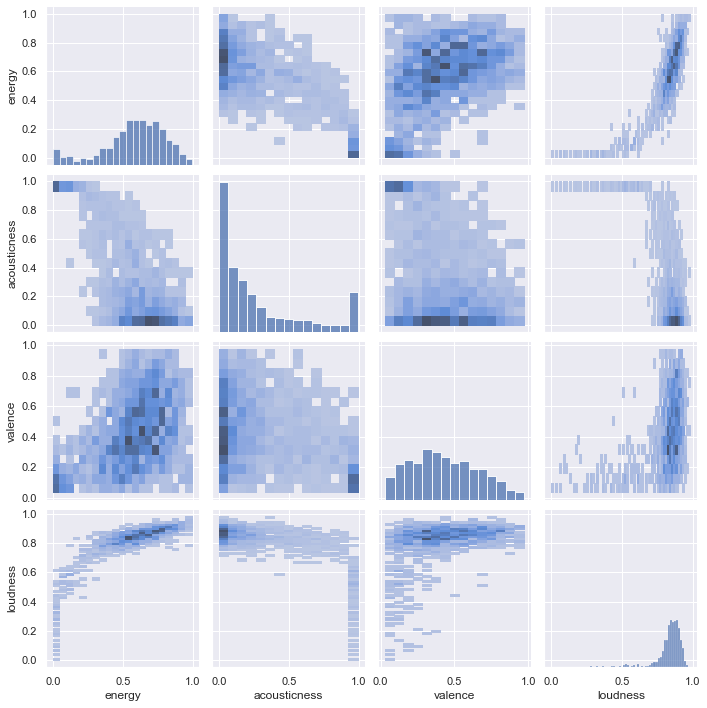

In [23]:
# plot only a subset of variables
scatter = MySongs[['energy', 'acousticness', 'valence', 'loudness']]
sns.pairplot(scatter, kind='hist')
plt.show()

As mentioned before, a radar chart is great way to visualize audio features. However, it is not very useful here since my library contains songs from various genres and a simple average of them does not say much or may in fact even disguise any insights. Nevertheless, I present the plot below.

In [24]:
s = MySongs.mean()[radar_vars]
fig = px.line_polar(r=s, theta=s.index, line_close=True, range_r=(0,1),
                    title = 'Average over all Songs in my Library')
fig.update_traces(fill='toself')
# fig.write_image("images/mysongs.png")
fig.show()

### 3.4 Cluster Analysis and Dimensionality Reduction
The above plot is not very meaningful as it averages over all tracks in my library. Consequently, I want to cluster my library into subgroups of more similar songs. Many clustering algorithms exist, but I stick to the most common one, k-means clustering because it is both effective and fast.

Subsequently, I apply k-means clustering to my dataset and analyze the results in a table as well as visually. In order to do that, I make use of dimensionality reduction methods - initially I apply a principal component analysis (PCA), which projects the audio features into a two-dimensional subspace by means of a linear combination of the original features. In addition, I also explore other, more flexible dimensionality reduction techniques to see if they can separate the clusters more clearly.

#### K-Means Clustering
The hyperparameter to specify for k-means clustering is the number of clusters. There are several systematic approaches to finding an optimal k such as the "elbow' method. However, I use a more subjective approach here by simply experimenting with several values to find a good k. Importantly, the number of clusters should not be too large as this would make interpretations very difficult. Eventually, I found that three clusters give good results.

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding

In [26]:
# minmax scaling to ensure all features are in [0,1]
minmax = MinMaxScaler().fit_transform(features)

# perform a k means clustering
kmeans = KMeans(n_clusters=3, random_state=445)
kmeans.fit(minmax, )

# add cluster lables and group by 
MySongs['label'] = kmeans.labels_
MySongs.groupby('label').mean()

popularity  danceability    energy  loudness  speechiness  \
label                                                              
0        0.499630      0.372556  0.086096  0.453949     0.051353   
1        0.628356      0.699811  0.667169  0.863507     0.134216   
2        0.649430      0.615875  0.456411  0.810368     0.090669   

       acousticness  instrumentalness   valence     tempo  liveness  
label                                                                
0          0.983167          0.911509  0.152508  0.451741  0.110449  
1          0.116928          0.019551  0.482794  0.499157  0.179239  
2          0.607183          0.007843  0.366628  0.465104  0.156726

The most obvious observation from the table is that there is one cluster that appears to be extremely acoustic and instrumental. Tracks in that cluster are also much slower, have less valence and liveness than songs in the other two clusters. The following visualizations will make that even clearer.

#### Principal Component Analysis (PCA)

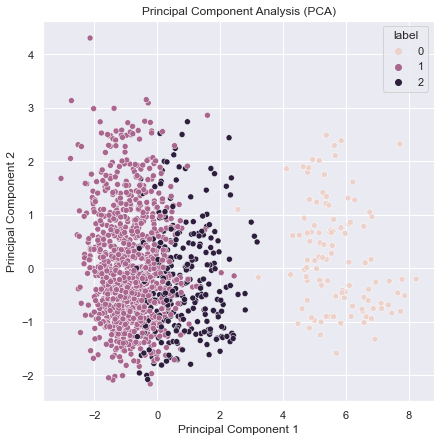

In [28]:
# run again if error
standardized = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(standardized)
X_pca = pd.DataFrame(X_pca, columns=['x', 'y'])
X_pca['label'] = MySongs['label'].to_list()

# plot PCA
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=X_pca, x='x', y='y', hue='label')
plt.title('Principal Component Analysis (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

PCA can separate the groups quite well. One group was perfectly separated whereas the other two clusters are overlapping. Not surprisingly, the cluster that is perfectly separable is the one that is characterized by high acousticness and instrumentalness.

A look at the explained variance of the two first principal components (see image below) reveals that they explain roughly 55 percent of the variance in the features. With five components, we can already explain more than 80 percent of the variance, and with six components that number above 90 percent.

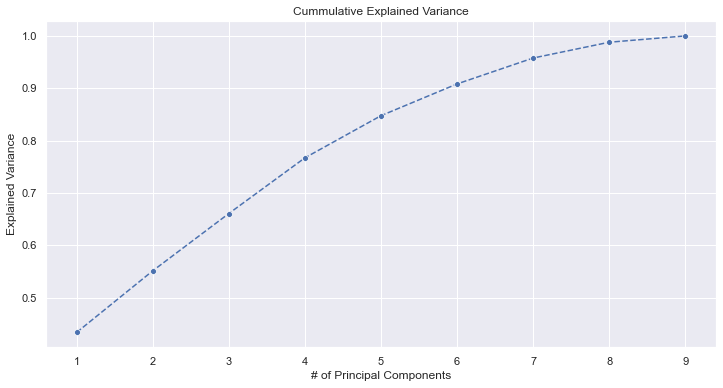

In [29]:
# converges only every second time
pca = PCA().fit(standardized)
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=range(1, len(features.columns)+1), y=exp_var.cumsum(), marker='o', linestyle='--')
plt.title('Cummulative Explained Variance')
plt.xlabel('# of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

#### Other Embedding Methods

PCA cannot easily separate two of the clusters. Generally speaking, this is no surprise as it relies on a linear combination of the original features. However, as already discussed, some features appear to have a non-linear relationship. Below, I therefore apply more powerful dimensionality reduction methods such as **TSNE, Isomap, Locally Linear Embedding, and Spectral Embedding** to see if they provide better results.

In [30]:
tsne = TSNE()
X_tsne = tsne.fit_transform(minmax)
X_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
X_tsne['label'] = kmeans.labels_

iso = Isomap()
X_iso = iso.fit_transform(minmax)
X_iso = pd.DataFrame(X_iso, columns=['x', 'y'])
X_iso['label'] = kmeans.labels_

lln = LocallyLinearEmbedding()
X_lln = lln.fit_transform(minmax)
X_lln = pd.DataFrame(X_lln, columns=['x', 'y'])
X_lln['label'] = kmeans.labels_

spec = SpectralEmbedding()
X_spec = spec.fit_transform(minmax)
X_spec = pd.DataFrame(X_spec, columns=['x', 'y'])
X_spec['label'] = kmeans.labels_

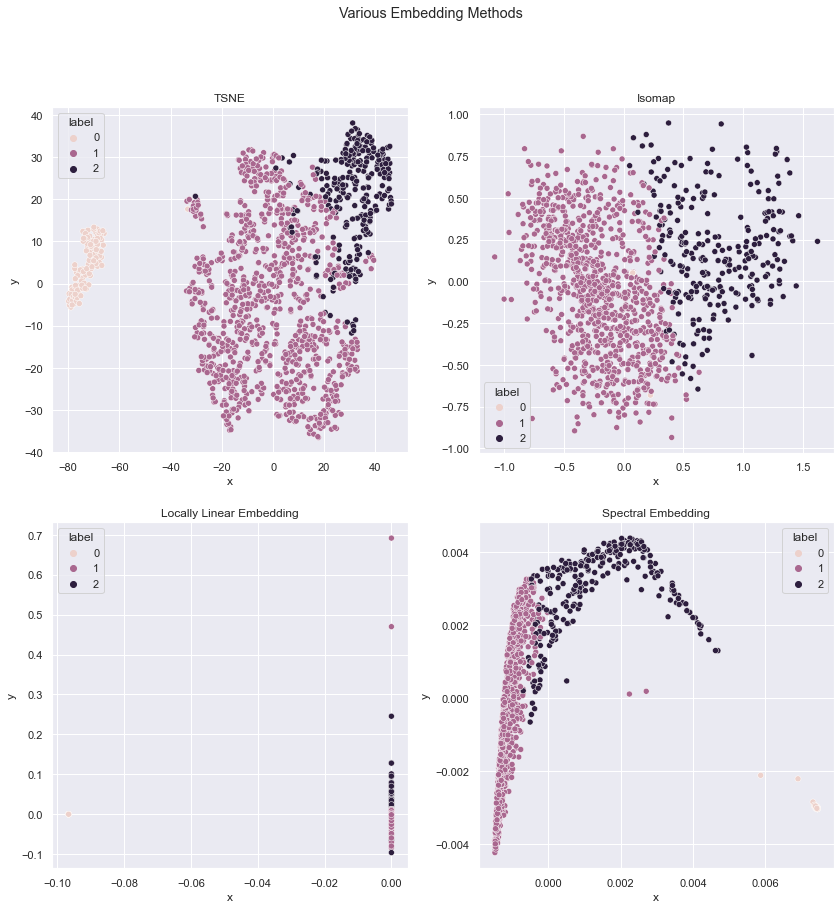

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,14))
fig.suptitle('Various Embedding Methods')
# TSNE
sns.scatterplot(data=X_tsne, x='x', y='y', hue='label', ax=ax1)
ax1.title.set_text('TSNE')
# Iso
sns.scatterplot(data=X_iso, x='x', y='y', hue='label', ax=ax2)
ax2.title.set_text('Isomap')
# LLN
sns.scatterplot(data=X_lln, x='x', y='y', hue='label', ax=ax3)
ax3.title.set_text('Locally Linear Embedding')
# Spec
sns.scatterplot(data=X_spec, x='x', y='y', hue='label', ax=ax4)
ax4.title.set_text('Spectral Embedding')

plt.show()

The results appear to be quite similar, so the improvement is only small, if any. Like PCA, all four methods easily sperate the "acoustic" cluster from the other two. In fact, Spectral Embedding and LLE even squash it (almost) into a single point, indicating that the cluster is very homogeneous. Moreover, with respect to the computational effort required for the methods, all can easily handle the approximately matrix of dimensionality $1300\times9$; the fitting procedure takes less than 30 seconds for all four methods on a standard CPU.

#### Results of the K-Means Clustering
The results obtained from the clustering can now be summarized effectively in the form of a radar chart and we can observe any differences and similarities between the three clusters.

In [32]:
radar_vars = ['popularity', 'danceability', 'energy', 'speechiness', 
              'acousticness', 'instrumentalness', 'valence', 'tempo']

cluster_means = [MySongs[MySongs.label==i].mean()[radar_vars].to_list() for i in range(3)]

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=cluster_means[0],
      theta=radar_vars,
      fill='toself',
      name='Cluster 1'
))
fig.add_trace(go.Scatterpolar(
      r=cluster_means[1],
      theta=radar_vars,
      fill='toself',
      name='Cluster 2'
))
fig.add_trace(go.Scatterpolar(
      r=cluster_means[2],
      theta=radar_vars,
      fill='toself',
      name='Cluster 3'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True,
    title = 'Summary of Clusters'
)
# fig.write_image("images/clusters.png")
fig.show()

> **Note**: Click on the labels to fade-in/fade-out the clusters.

There are some striking differences between the three clusters, which indicates that the algorithm was indeed able to recognize major patterns in my Spotify library. Equipped with these results, I interpret the clusters in the following way.

##### Cluster 1 (blue) - Instrumental/Acoustic Tracks
Cluster 1 is characterized by high instrumentalness and acousticness, but low valence, energy and danceability. Interestingly, the average tempo is not much different from the other clusters. Most likely, this cluster consists primarily of the piano tracks in my library, which are very distinct from most other songs. Here are 3 songs from that cluster. Click on the links below to hear a 30 seconds preview.

In [33]:
def print_urls(df):
    res = sp.tracks(df.index)
    print('\nClick on the links to hear a 30 seconds preview.')
    for track in res['tracks']:
        name = track['name']; artist = track['artists'][0]['name']
        link = track['preview_url']
        display(HTML(f'{name} by {artist} - <a href="{link}"> preview</a>'))
        
cluster1 = MySongs[MySongs.label==0]
print('# songs in cluster 1:', len(cluster1))
c1 = cluster1.head(3)
display(c1)
print_urls(c1)

# songs in cluster 1: 108


name  \
id                                                                          
1dWxSS2a93X4XVfs1mSYkB                                           Bluebird   
7etGs69UCKGxJIHxKFe7BD                                 River Flows in You   
3Dgmyz32dxvtxvUTPS0CUI  Vivaldi Variation (Arr. for Piano from Concert...   

                        popularity  danceability  energy  loudness  \
id                                                                   
1dWxSS2a93X4XVfs1mSYkB        0.62         0.448   0.111  0.530091   
7etGs69UCKGxJIHxKFe7BD        0.55         0.223   0.183  0.522998   
3Dgmyz32dxvtxvUTPS0CUI        0.64         0.429   0.258  0.613076   

                        speechiness  acousticness  instrumentalness  valence  \
id                                                                             
1dWxSS2a93X4XVfs1mSYkB       0.0353         0.991             0.898   0.0755   
7etGs69UCKGxJIHxKFe7BD       0.0491         0.988             0.918   0.1860   
3Dgmyz32dxvtxvUTPS0CUI       0.0549         0.957             0.893   0.0972   

                           tempo  liveness  label  
id                                                 
1dWxSS2a93X4XVfs1mSYkB  0.306393    0.0974      0  
7etGs69UCKGxJIHxKFe7BD  0.294811    0.1030      0  
3Dgmyz32dxvtxvUTPS0CUI  0.322988    0.1150      0


Click on the links to hear a 30 seconds preview.


##### Cluster 2 (red) - Energetic Tracks
This cluster is full of high-energy, danceable, happy songs. Unsurprisingly, acousticness and instrumentalness are low. The cluster most likely includes all my energetic pop and hip-hop songs as well as the electronic songs in my library. With over 900 songs, it is the largest cluster. Here are some tracks from cluster 2.

In [34]:
cluster2 = MySongs[MySongs.label==1]
print('# songs in cluster 2:', len(cluster2))
c2 = cluster2.head(3)
display(c2)
print_urls(c2)

# songs in cluster 2: 967


name  popularity  danceability  \
id                                                                           
3YZE5qDV7u1ZD1gZc47ZeR       Underneath the Tree        0.75         0.509   
0lizgQ7Qw35od7CYaoMBZb             Santa Tell Me        0.86         0.525   
0YWUHZPJVg4iujddsJDwhM  My Only Wish (This Year)        0.74         0.669   

                        energy  loudness  speechiness  acousticness  \
id                                                                    
3YZE5qDV7u1ZD1gZc47ZeR   0.812  0.875966       0.0537       0.00128   
0lizgQ7Qw35od7CYaoMBZb   0.621  0.832068       0.1160       0.04890   
0YWUHZPJVg4iujddsJDwhM   0.843  0.914118       0.0268       0.16900   

                        instrumentalness  valence     tempo  liveness  label  
id                                                                            
3YZE5qDV7u1ZD1gZc47ZeR           0.00002    0.689  0.655238     0.214      1  
0lizgQ7Qw35od7CYaoMBZb           0.00000    0.591  0.786475     0.294      1  
0YWUHZPJVg4iujddsJDwhM           0.00000    0.702  0.602787     0.195      1


Click on the links to hear a 30 seconds preview.


##### Cluster 3 (green) - Moderate Tracks
Songs in this cluster are more moderate in most features. They are slightly slower than the energetic songs as well as less danceable and happy. Interestingly, it seems to be the category that scores highest on popularity. I therefore expect the cluster to contain primarily pop songs, which are generally more mainstream and popular.

In [35]:
cluster3 = MySongs[MySongs.label==2]
print('# songs in cluster 3:', len(cluster3))
c3 = cluster3.head(3)
display(c3)
print_urls(c3)

# songs in cluster 3: 263


name  \
id                                                                        
1QLZKzC2pjP4ySf4ALrNhm                            Christmas Without You   
0RE4crnT3jRms1xxVlEZx2                                          Bad boy   
4VEEDnEFLI9dUy5QA51rom  fools (can't help falling in love) (feat. Sody)   

                        popularity  danceability  energy  loudness  \
id                                                                   
1QLZKzC2pjP4ySf4ALrNhm        0.75         0.654   0.596  0.893275   
0RE4crnT3jRms1xxVlEZx2        0.79         0.796   0.496  0.813801   
4VEEDnEFLI9dUy5QA51rom        0.74         0.706   0.604  0.841919   

                        speechiness  acousticness  instrumentalness  valence  \
id                                                                             
1QLZKzC2pjP4ySf4ALrNhm       0.0458         0.424          0.000000    0.382   
0RE4crnT3jRms1xxVlEZx2       0.0388         0.431          0.000006    0.716   
4VEEDnEFLI9dUy5QA51rom       0.3030         0.418          0.000000    0.361   

                           tempo  liveness  label  
id                                                 
1QLZKzC2pjP4ySf4ALrNhm  0.483926    0.1100      2  
0RE4crnT3jRms1xxVlEZx2  0.401590    0.0781      2  
4VEEDnEFLI9dUy5QA51rom  0.336189    0.2420      2


Click on the links to hear a 30 seconds preview.


The following visualizations provide even more insights about the results of the clustering. Clearly, some features are more helpful for separating the groups than others. For example, there are apparent differences in both energy and acousticness between the clusters whereas speechiness and tempo alone are quite similar.

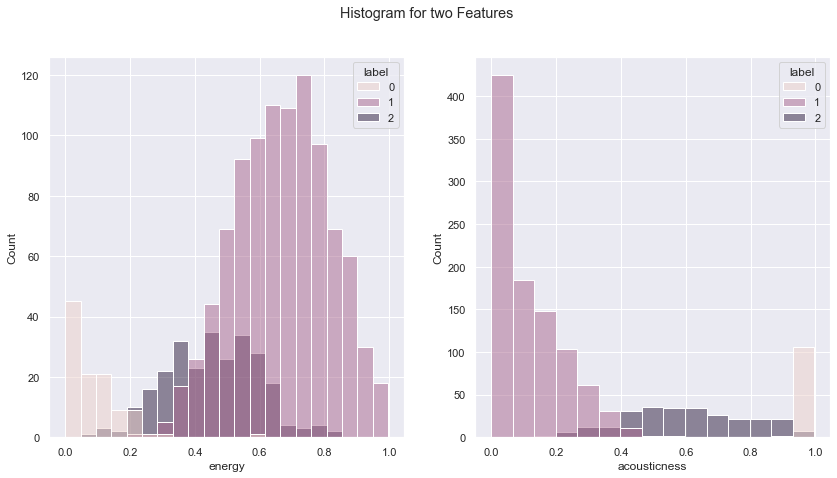

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
fig.suptitle('Histogram for two Features')
# TSNE
sns.histplot(MySongs, x="energy", hue="label", ax=ax1)
sns.histplot(MySongs, x="acousticness", hue="label", ax=ax2)
plt.show()

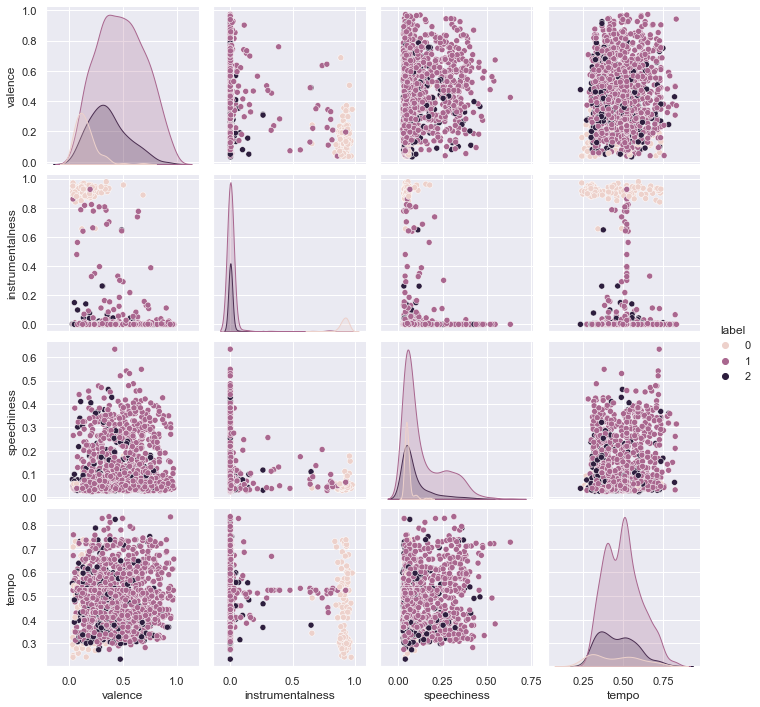

In [37]:
scatter = MySongs[['valence', 'instrumentalness', 'speechiness', 'tempo', 'label']]
sns.pairplot(scatter, hue='label')
plt.show()

Given the results of the clustering, I could create three new playlist and add them to my library - the Spotify API provides a method to facilitate this. However, these playlists would be too large (>300 songs on average).

## 4. Predicting Popular Songs
In this section, I investigate if audio features can be used to predict whether a song is popular or not. I also take a closer look at which features are most important in determining popularity.

Because my dataset of roughly 1.300 songs is still quite small for this task, I use a larger, publicly available dataset from Kaggle containing some 160,000 songs which were also collected via the Spotify Web API. The dataset therefore contains the very same structure and audio features. For more information, see the [Spotify Dataset on Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks).

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [39]:
# read the data from csv file
spotify_all = pd.read_csv('data/spotify.csv', index_col='id')
spotify = spotify_all.drop(['artists', 'name', 'release_date', 'year'], axis=1)
print('dimensions:', spotify.shape)
spotify.head()

dimensions: (169909, 14)


acousticness  danceability  duration_ms  energy  \
id                                                                        
6KbQ3uYMLKb5jDxLF7wYDD         0.995         0.708       158648  0.1950   
6KuQTIu1KoTTkLXKrwlLPV         0.994         0.379       282133  0.0135   
6L63VW0PibdM1HDSBoqnoM         0.604         0.749       104300  0.2200   
6M94FkXd15sOAOQYRnWPN8         0.995         0.781       180760  0.1300   
6N6tiFZ9vLTSOIxkj8qKrd         0.990         0.210       687733  0.2040   

                        explicit  instrumentalness  key  liveness  loudness  \
id                                                                            
6KbQ3uYMLKb5jDxLF7wYDD         0             0.563   10    0.1510   -12.428   
6KuQTIu1KoTTkLXKrwlLPV         0             0.901    8    0.0763   -28.454   
6L63VW0PibdM1HDSBoqnoM         0             0.000    5    0.1190   -19.924   
6M94FkXd15sOAOQYRnWPN8         0             0.887    1    0.1110   -14.734   
6N6tiFZ9vLTSOIxkj8qKrd         0             0.908   11    0.0980   -16.829   

                        mode  popularity  speechiness    tempo  valence  
id                                                                       
6KbQ3uYMLKb5jDxLF7wYDD     1           0       0.0506  118.469   0.7790  
6KuQTIu1KoTTkLXKrwlLPV     1           0       0.0462   83.972   0.0767  
6L63VW0PibdM1HDSBoqnoM     0           0       0.9290  107.177   0.8800  
6M94FkXd15sOAOQYRnWPN8     0           0       0.0926  108.003   0.7200  
6N6tiFZ9vLTSOIxkj8qKrd     1           1       0.0424   62.149   0.0693

Since popularity is a continuous variable (between 0 and 100, or 0 and 1 after scaling), the variable would be a better fit for a regression model. However, my goal is only to distinguish popular songs from unpopular ones. I therefore create a dummy variable that is 1 if the popularity of a track is at least 30 (a reasonable amount of popularity) and 0 otherwise.

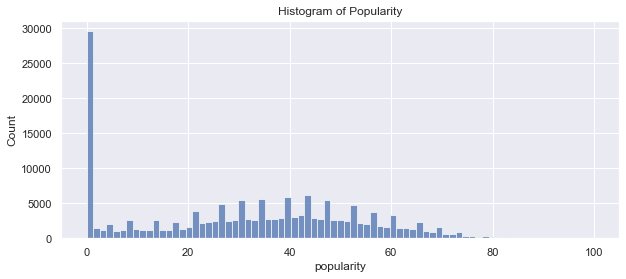

In [40]:
# plot the distibution of popularity
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(spotify.popularity)
plt.title('Histogram of Popularity')
plt.show()

> **Note**: We could exclude the large number of songs that have zero popularity as they may simply do not have a record for that feature. However, I decided not to remove them here as they may also represent the large number of songs that never get recognized because they are distinctively bad, and we would definitely want to predict them correctly.

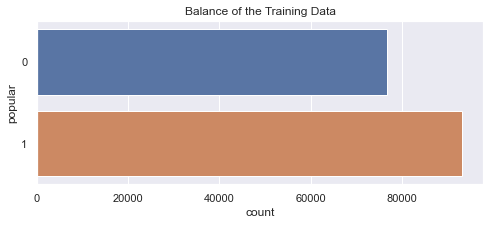

In [41]:
# create a dummy variable for classification
spotify['popular'] = [1 if p>30 else 0 for p in spotify.popularity]

fig, ax = plt.subplots(figsize=(8,3))
sns.countplot(y=spotify.popular)
plt.title('Balance of the Training Data')
plt.show()

I split the data into a training and test set (80 vs 20 percent), and train various classifiers using scikit-learn.

In [42]:
# 80/20 train test split
X_train, X_test, y_train, y_test = train_test_split(spotify.drop(['popular', 'popularity'], axis=1), 
                                                    spotify['popular'])
print(f'# of training samples: {y_train.shape[0]}\n# of test samples: {y_test.shape[0]}')

# of training samples: 127431
# of test samples: 42478


In [43]:
classifiers = [LogisticRegression(penalty='l1', solver='liblinear'),
               GaussianNB(),
               RandomForestClassifier(n_estimators=10),
               AdaBoostClassifier(n_estimators=10)]

>**Note**: Scikit-Learn offers many classifiers. I choose those four because they are sufficiently different from each other and are some of the most widely used. Also note that due to the large dataset, I choose a relatively low number of trees (n_estimators) for both Random Forest and AdaBoost.

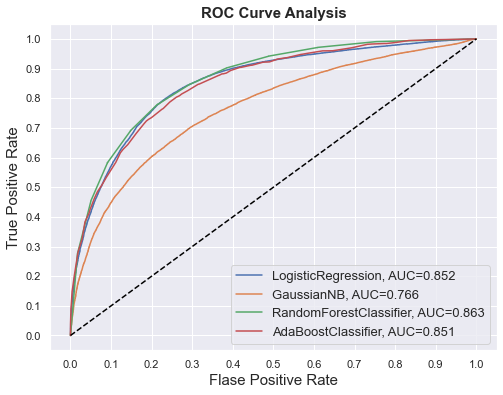

In [44]:
# credits for this code chunk to Imran. Could not find a better way to code this.
# see https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))
for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

> **Note**: Credits for the above code chunk to Imran (see blog post [here](https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot)).

All classifiers do much better than chance. Therefore, it appears to be possible to make inferences about a track's popularity from its audio features. Among the used methods, the Random Forest achieves the best results as it has the largest AUC and is the "closest" to the upper left corner. The Naive Bayes classifier, arguably the simplest classifier, does the worst. Since I did not tune the models, however, the results should just be taken as a rough indicator for the performance of the methods.

Furthermore, calculating **permutation importances** can reveal which features contributed most to the classifier's ability to perform well on the task (using the Random Forest classifier since it does best here). We can see that acousticness, loudness and duration have the highest scores whereas mode, explicitness, and key have the lowest. This does not, however, tell us if the features are associated with more or less popularity. Generally speaking, we would expect features that have large **absolute** correlations with popularity to also exhibit high importance scores.

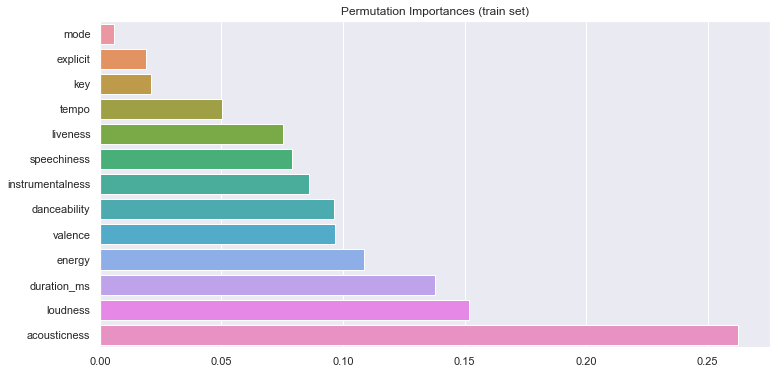

In [45]:
rf = classifiers[2]
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=result.importances[sorted_idx].mean(axis=1), y=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
plt.show()

## 5. Network Analysis
In this final chapter of the notebook, I explore how often artists collaborate using network analysis methods. In particular, I would like to know if there are any groups of artists that collaborate more frequently with each other. In addition, I also want to find the ten most collaborative artists. In this section I again use the Kaggle dataset which contains around 160,000 songs.

In [46]:
import networkx as nx
import ast

In [47]:
# dataset
spotify_all.artists.head()

id
6KbQ3uYMLKb5jDxLF7wYDD                         ['Carl Woitschach']
6KuQTIu1KoTTkLXKrwlLPV    ['Robert Schumann', 'Vladimir Horowitz']
6L63VW0PibdM1HDSBoqnoM                     ['Seweryn Goszczyński']
6M94FkXd15sOAOQYRnWPN8                        ['Francisco Canaro']
6N6tiFZ9vLTSOIxkj8qKrd    ['Frédéric Chopin', 'Vladimir Horowitz']
Name: artists, dtype: object

The challenge here is to transform the data from the above "list of lists of artists" into an undirected graph that correctly places an edge between two artists that have collaborated on a song. For example, there should be an edge between Robert Schumann and Vladimir Horowitz as there is at least one song on which the two artists collaborated.

In [48]:
# get a list of all artists in the dataframe
colab = spotify_all.loc[spotify_all.year >= 2000]['artists']
colab = [ast.literal_eval(sublist) for sublist in colab]

# nested list comprehension to create a single list
# use set to get rid of duplicates
all_artists = set([art for sublist in colab for art in sublist])
print("# of artists:", len(all_artists))

# turn the list of artists into an edgelist that can be turned into a networkx graph
edges = {art[0]: art[1:] for art in colab}

# of artists: 12098


> **Note**: I use only data from the year 2000 onwards as these are the artists I am most interested in.

In [49]:
# turn edgelist into graph
G = nx.Graph(edges)

# remove artists with no collaborations
G.remove_nodes_from(list(nx.isolates(G)))
print("# of artists with at least one collaboration:", len(list(G.nodes)))

# of artists with at least one collaboration: 3536


In [50]:
# keep only node with at least 2 collaborations
keep = [node for node, degree in dict(G.degree()).items() if degree >= 3]
K = G.subgraph(keep)
print("# of artists with at least two collaborations:", len(list(K.nodes)))

# of artists with at least two collaborations: 467


We can see that out of the approximately 12.000 artists, only 3.500 have at least one collaboration (29%), and less than 500 have at least two (4%). The top 10 most collaborative artists are the following (including their numbers of collaborations).

In [51]:
# find the most collaborative artists
n_collab = sorted(G.degree, key=lambda x: x[1], reverse=True)
n_collab[:10]

[('Warren Haynes', 21),
 ('Michael Potts', 13),
 ('Bad Bunny', 11),
 ('Lin-Manuel Miranda', 11),
 ('Lea Michele', 10),
 ('Future', 10),
 ('Tyga', 10),
 ('Anuel AA', 10),
 ('Brian Johnson', 10),
 ('Daddy Yankee', 9)]

Using NetworkX, it is also possible to find the largest connected subgraph. It contains 690 artists and is plotted below. Even within this subgraph we can see that most artists never collaborate.

> **Note**: This dataset is only a tiny subset of the full Spotify Catalogue (remember that it contains some 60 Mio. songs), so some artists may be very collaborative but are only listed once in this dataset.

# of nodes 690


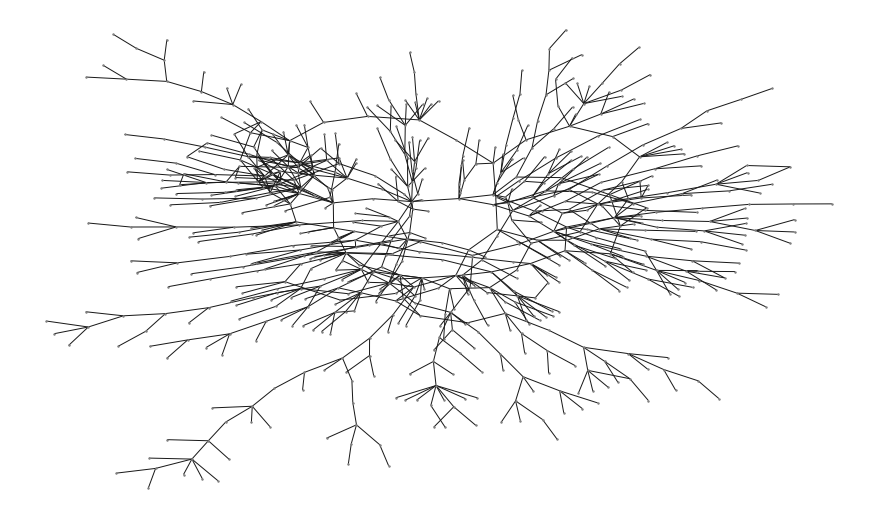

In [52]:
# plot largest subgraph
options = {
    'node_color': 'grey',
    'node_size': 2,
    'width': 1,
}

components = sorted(nx.connected_components(G), key=len, reverse=True)
giant = G.subgraph(components[0])
print("# of nodes", len(giant.nodes()))
fig = plt.figure(figsize=(12,7))
nx.draw_kamada_kawai(giant, **options)
plt.show()

Among those artists in the largest connected subgraph, we can use **seriation** to spot any structural information such as subgroups of artists that collaborate particularly often. There are not striking patterns (image below), but we can see again that some artists appear to be more collaborative while most have very few collaborations.

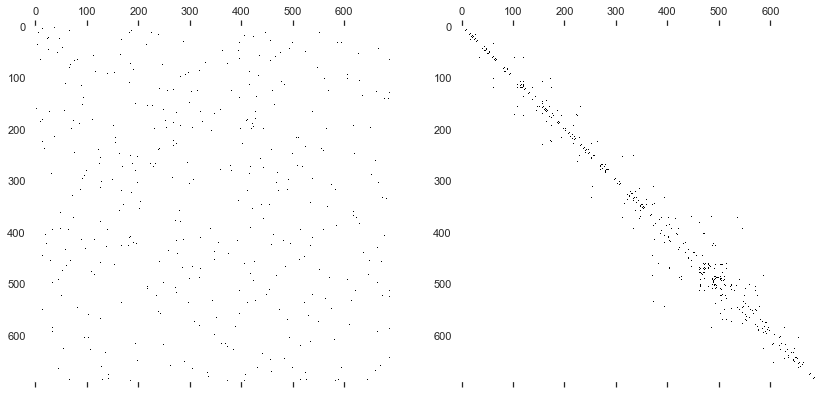

In [53]:
adjM = nx.adjacency_matrix(giant)
adjM = adjM.toarray()

# compute the Laplacian matrix
L = np.diag(np.sum(adjM,1)) - adjM

# compute eigenvalues and eigenvectors of the Laplacian matrix
D, V = np.linalg.eigh(L)
argD = np.argsort(D)
D=D[argD]
V=V[:,argD]

# get the Fiedler eigenvector and permute the order
fiedler = V[:,1]
Fperm = np.argsort(fiedler)
Aperm2 = adjM[Fperm,:]
Aperm2 = Aperm2[:,Fperm]

# plot of the matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,12))
ax1.matshow(adjM, cmap=plt.cm.gray_r)
ax2.matshow(Aperm2, cmap=plt.cm.gray_r)
plt.show()

# 6. Conclusion

The goals of this notebook are to analyze as well as visualize my music preferences using data obtained via the Spotify API while also applying many of the tools learned in class along the way. The following six conclusions are a concise summary of what I already described in more detail in each subsection of the notebook.

- **Conclusion 1**: The audio features defined by Spotify are a great way of "quantifying" songs and music preferences. Radar charts are particularly well suited to visualize them.

- **Conclusion 2**: My Spotify library comprises (at least) three subgroups of tracks that are more similar _with_ each other and distinct _from_ each other. These subgroups can be interpreted as Acoustic Songs, Energetic Songs, and Moderate Songs.

- **Conclusion 3**: Since cluster 2 is the largest (Energetic Songs), it appears that generally I prefer songs that score high on energy, danceability, and valence, but low on acousticness and instrumentalness. However, some songs are quite the opposite (very acoustic and instrumental), so the data does not reveal an absolute preference.

- **Conclusion 4**: Principal Component Analysis (PCA) can separate the three clusters quite well. Non-linear methods such as TSNE lead to only marginal improvements.

- **Conclusion 5**: A tack's audio features contain considerable information about its popularity. In other words, it is possible to use audio features to predict the popularity of a song with accuracy that far exceeds chance. Indeed, many recommendation systems make use of audio features.

- **Conclusion 6**: Most artists are solo artists, i.e. they never collaborate with other artists. At the same time, however, subgroups of artists that collaborate more frequently with each other exist as well.

**There are several ways in which this analysis can be improved or extended**. To begin with, I deliberately have not made use of _genres_ throughout the notebook. This has several reasons. First of all, it is not an "audio feature" as defined by Spotify. Additionally, it is often difficult to categorize a song into a specific genre as genre boundaries are generally very fluid. Nevertheless, including genre as an additional variable may still provide some valuable insight. For example, it would be intriguing to characterize the obtained clusters in terms of the major genres they comprise.

Furthermore, as mentioned previously, predicting the popularity of a song is naturally a regression task as the variable at hand is continuous. However, in order to incorporate an ROC analysis (a topic learned in class), I decided to turn it into a classification problem, a technique that is not uncommon in practice too. Additionally, the choice of the four classifiers may appear quite random. Not to mention that they should be tuned in practice (while scikit-learn's default parameter values work surprisingly well in many situations, they may work badly in others). Another improvement would be to provide more insights into which features contribute to popularity of a song and which do not. The importance scores is a first good step. However, as mentioned, it does not reveal which features contribute to higher versus lower popularity.

Lastly, there are also many ways in which network analysis can be used to further extend this notebook. For example, it would be interesting to find out whether artists who collaborate frequently are more popular than artist who do not. In addition, there are more advanced graph visualization libraries that go way beyond the built-in plotting capabilities of the NetworkX library. They would allow me to visualize any network structures much more effectively.

In [57]:
!jupyter nbconvert --to html ST445-Project-Notebook.ipynb

[NbConvertApp] Converting notebook ST445-Project-Notebook.ipynb to html
[NbConvertApp] Writing 5689760 bytes to ST445-Project-Notebook.html
